In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle
from scipy import stats

# 载入数据

In [2]:
#python2
with open('predict_train_test_data.pickle', 'rb') as handle:
    data = pickle.load(handle,) #python2
    
    
    
trainX      = data['x_train_new']
trainY      = data['trainY']
testX       = data['x_test_new']
testY       = data['testY']
del data

# 朴素贝叶斯分类器

In [3]:
#Probability distribution list
def PDL(Y):
    label = np.unique(Y)#列出所有标签
    #pdl = np.zeros_like(label)
    count = np.zeros_like(label)
    total = len(Y)
    for i in range(len(label)):#统计各个标签数量
        count[i] = np.count_nonzero(Y==label[i])
        
    pdl = count*1.0/total#计算各个类出现的概率
    
    return pdl

In [4]:
# probability density function 
def PDF(x):
    kde = stats.gaussian_kde(x, bw_method='scott')#使用stats中的高斯核非参数估计
    bw = kde.scotts_factor() * np.std(x)#带宽计算，使用
    clip = (-np.inf, np.inf)
    gridsize = 100#pdf点数
    cut = 4
    support_min = max(x.min() - bw * cut, clip[0])
    support_max = min(x.max() + bw * cut, clip[1])
    grid = np.linspace(support_min, support_max, gridsize)
    y = kde(grid)
    x, y =grid, y
    y = np.amax(np.c_[np.zeros_like(y), y], axis=1)
    return [x,y]

In [5]:
def PDF_x_Y(nc,nf,X,Y):#nc类别数nf特征数
    nf = X.shape[1]
    label = np.unique(Y)
    nc = label.shape[0]
    pdfs=[]
    for i in range(nc):#pdf每个y有一组pdf，对应于各个特征p(xi|y),i=0,1,2...
        pdfs.append([])
        for j in range(nf):
            pdfs[i].append(PDF(X[np.nonzero(Y==label[i])][:,j]))
    return pdfs

In [6]:
#对一个样本进行预测
def Predect(X,p_y,pdfs,label,nf,nc):
    ups = np.zeros(nc)
    for j in range(nc): #对每个类，找到找到各个特征值对应的概率密度
        up = 1
        for n in range(nf):#循环求得概率密度
            x=pdfs[j][n][0]#类别j的第n个特征的pdf
            y=pdfs[j][n][1]
                
            index=np.nonzero(x>=X[n])[0]
            if len(index)==0:
                index=-1
            else:
                index = index[0]
            #print(i,n)
            up=up*y[index]#可能为0
        up = up*p_y[j]#将概率密度与p(y=i)相乘得到分子
        ups[j]=up#分母为所有分子的和，保存所有分子
    down = np.sum(ups)#分母
    p=ups*1.0/down#p(y=j|x=i),即当样本为i时类别为j的概率
    m = p.argmax(axis=0)#取概率最大值
    pre=label[m]
    return pre

In [7]:
#分类器，对一批样本预测
def Classifier(test,p_y,pdfs,label,nf,nc):
    #pre = np.zeros([len(test),nc])
    predict = np.zeros(len(test))
    for i in range(len(test)):
        predict[i]=Predect(test[i],p_y,pdfs,label,nf,nc)
    return predict

# 取3类进行训练和测试

In [8]:
#训练集，用于构造分类器
index=np.nonzero(trainY<=2)
train_3X = trainX[index]
train_3Y = trainY[index]

#测试集，用于测试分类器
index=np.nonzero(testY<=2)
test_3X = testX[index]
test_3Y = testY[index]

(100.0, '%')
(85.19515477792731, '%')


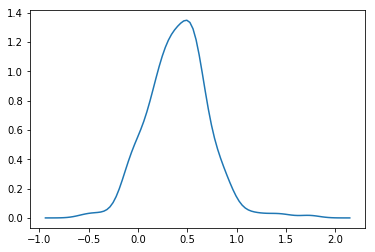

In [9]:
#训练 学习p(y)和p(x|y)
label = np.unique(train_3Y)
nc = label.shape[0]
nf = train_3X.shape[1]
p_y=PDL(train_3Y)
pdfs=PDF_x_Y(nc=nc,nf=nf,X=train_3X,Y=train_3Y)
#测试 对训练集和测试集分别进行
#训练集
pre = Classifier(train_3X,p_y,pdfs,label=label,nf=nf,nc=nc)
acc=np.count_nonzero(pre==train_3Y)
acc=acc*1.0/len(train_3Y)
print(acc*100,'%')
#测试集
pre = Classifier(test_3X,p_y,pdfs,label=label,nf=nf,nc=nc)
acc=np.count_nonzero(pre==test_3Y)
acc=acc*1.0/len(test_3Y)
print(acc*100,'%')
#画概率密度函数
plt.plot(pdfs[1][10][0],pdfs[1][10][1])
pdf3=[pdfs[1][10][0],pdfs[1][10][1]]

# 取10类进行训练和测试

(100.0, '%')
(91.4639175257732, '%')


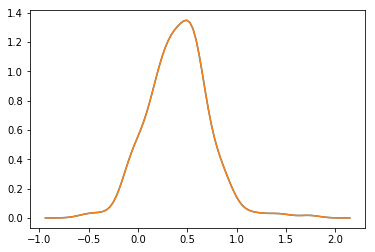

In [10]:
#训练 学习p(y)和p(x|y)
label = np.unique(trainY)
nc = label.shape[0]
nf = trainX.shape[1]
p_y=PDL(trainY)
pdfs=PDF_x_Y(nc=nc,nf=nf,X=trainX,Y=trainY)
#测试 对训练集和测试集分别进行
#训练集
pre = Classifier(trainX,p_y,pdfs,label=label,nf=nf,nc=nc)
acc=np.count_nonzero(pre==trainY)
acc=acc*1.0/len(trainY)
print(acc*100,'%') 
#测试集
pre = Classifier(testX,p_y,pdfs,label=label,nf=nf,nc=nc)
acc=np.count_nonzero(pre==testY)
acc=acc*1.0/len(testY)
print(acc*100,'%') 
#画概率密度函数
plt.plot(pdfs[1][10][0],pdfs[1][10][1])
plt.plot(pdf3[0],pdf3[1])

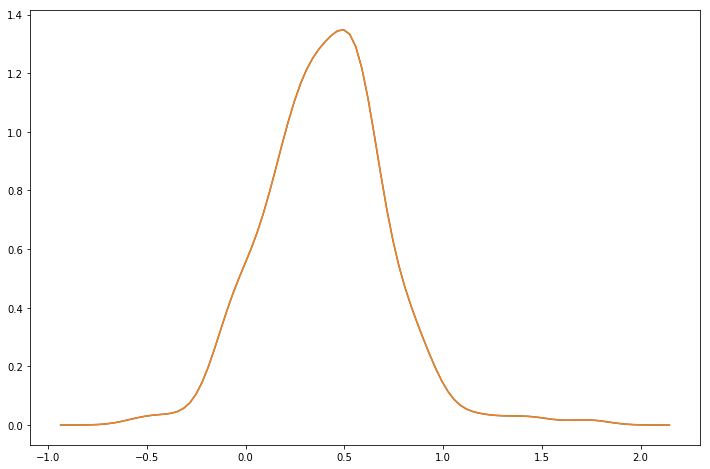

In [11]:
plt.figure(figsize=[12,8])
plt.plot(pdfs[1][10][0],pdfs[1][10][1])
plt.plot(pdf3[0],pdf3[1])

# 将训练集测试集混合打散后重新分配训练集和测试集

In [12]:
train_num=len(trainY)
test_num=len(testY)

X=np.vstack([trainX,testX])
Y=np.hstack([trainY,testY])

In [13]:
index = np.arange(len(Y))
np.random.seed(1)
np.random.shuffle(index)
X = X[index]
Y = Y[index]
trainX = X[0:train_num]
trainY = Y[0:train_num]
testX = X[train_num:]
testY = Y[train_num:]

## 再次取3类进行训练和分类

In [14]:
#训练集，用于构造分类器
index=np.nonzero(trainY<=2)
train_3X = trainX[index]
train_3Y = trainY[index]

#测试集，用于测试分类器
index=np.nonzero(testY<=2)
test_3X = testX[index]
test_3Y = testY[index]

(100.0, '%')
(99.86282578875172, '%')


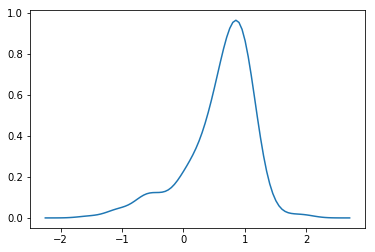

In [15]:
#训练 学习p(y)和p(x|y)
label = np.unique(train_3Y)
nc = label.shape[0]
nf = train_3X.shape[1]
p_y=PDL(train_3Y)
pdfs=PDF_x_Y(nc=nc,nf=nf,X=train_3X,Y=train_3Y)
#测试 对训练集和测试集分别进行
#训练集
pre = Classifier(train_3X,p_y,pdfs,label=label,nf=nf,nc=nc)
acc=np.count_nonzero(pre==train_3Y)
acc=acc*1.0/len(train_3Y)
print(acc*100,'%')
#测试集
pre = Classifier(test_3X,p_y,pdfs,label=label,nf=nf,nc=nc)
acc=np.count_nonzero(pre==test_3Y)
acc=acc*1.0/len(test_3Y)
print(acc*100,'%')
#画概率密度函数
plt.plot(pdfs[0][10][0],pdfs[0][10][1])
pdf3=[pdfs[0][10][0],pdfs[0][10][1]]

## 增量到10类

(99.85438660356752, '%')
(99.75257731958763, '%')


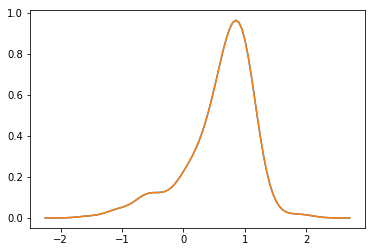

In [16]:
#训练 学习p(y)和p(x|y)
label = np.unique(trainY)
nc = label.shape[0]
nf = trainX.shape[1]
p_y=PDL(trainY)
pdfs=PDF_x_Y(nc=nc,nf=nf,X=trainX,Y=trainY)
#测试 对训练集和测试集分别进行
#训练集
pre = Classifier(trainX,p_y,pdfs,label=label,nf=nf,nc=nc)
acc=np.count_nonzero(pre==trainY)
acc=acc*1.0/len(trainY)
print(acc*100,'%')
#测试集
pre = Classifier(testX,p_y,pdfs,label=label,nf=nf,nc=nc)
acc=np.count_nonzero(pre==testY)
acc=acc*1.0/len(testY)
print(acc*100,'%')
#画概率密度函数
plt.plot(pdfs[0][10][0],pdfs[0][10][1])
plt.plot(pdf3[0],pdf3[1])

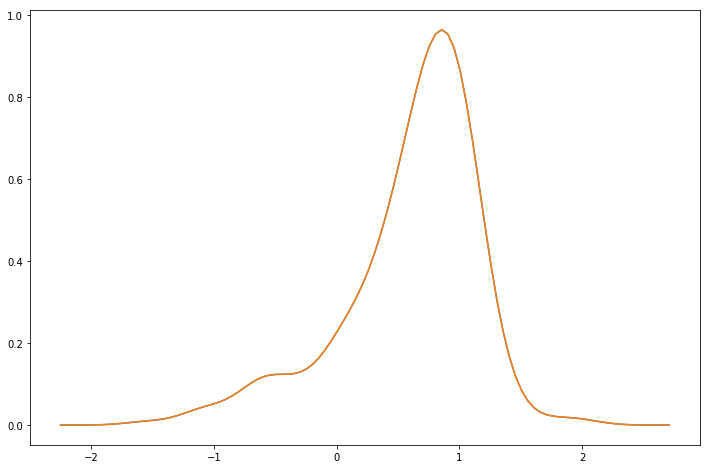

In [17]:
plt.figure(figsize=[12,8])
plt.plot(pdfs[0][10][0],pdfs[0][10][1])
plt.plot(pdf3[0],pdf3[1])

# 类内增量

In [18]:
#训练集，用于构造分类器
index=np.nonzero(trainY<=2)
train_3X = trainX[index][0:415]
train_3Y = trainY[index][0:415]

#测试集，用于测试分类器
index=np.nonzero(testY<=2)
test_3X = testX[index]
test_3Y = testY[index]
print(train_3X.shape)

(415L, 12L)


In [19]:
train_3Y

array([2, 1, 0, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 1, 0, 2, 1, 0, 1, 2, 0, 2,
       2, 2, 0, 1, 2, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       2, 2, 0, 1, 0, 1, 2, 0, 1, 2, 0, 2, 0, 2, 2, 2, 0, 1, 2, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 2, 0, 0, 2, 0, 2, 1, 2, 2, 1, 0, 1, 2, 2,
       2, 1, 2, 0, 0, 1, 1, 2, 0, 0, 1, 2, 2, 2, 2, 2, 1, 2, 0, 0, 2, 2,
       0, 0, 2, 2, 0, 2, 1, 2, 2, 2, 0, 1, 2, 0, 2, 1, 1, 0, 0, 2, 2, 1,
       1, 1, 0, 2, 1, 0, 0, 0, 2, 0, 0, 1, 0, 0, 2, 2, 1, 0, 1, 2, 0, 1,
       2, 2, 0, 2, 1, 0, 2, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 2,
       2, 0, 2, 0, 1, 0, 0, 2, 0, 2, 1, 0, 1, 2, 2, 2, 2, 1, 2, 2, 0, 0,
       1, 1, 2, 0, 0, 0, 2, 0, 2, 2, 0, 1, 0, 0, 0, 1, 0, 2, 2, 2, 2, 1,
       0, 2, 2, 2, 1, 2, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 2, 1, 2, 1, 0, 0,
       2, 1, 1, 1, 2, 0, 2, 0, 0, 2, 2, 1, 2, 1, 0, 1, 0, 0, 2, 1, 0, 1,
       2, 0, 2, 1, 2, 0, 2, 0, 0, 1, 1, 2, 1, 0, 2, 1, 1, 2, 1, 2, 2, 2,
       2, 1, 2, 2, 0, 1, 0, 1, 1, 2, 0, 1, 1, 0, 0,

(100.0, '%')
(99.86282578875172, '%')


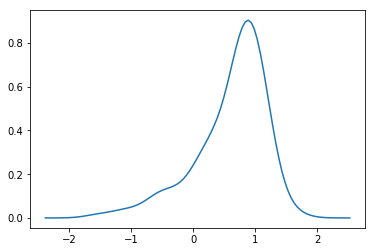

In [20]:
#训练 学习p(y)和p(x|y)
label = np.unique(train_3Y)
nc = label.shape[0]
nf = train_3X.shape[1]
p_y=PDL(train_3Y)
pdfs=PDF_x_Y(nc=nc,nf=nf,X=train_3X,Y=train_3Y)
#测试 对训练集和测试集分别进行
#训练集
pre = Classifier(train_3X,p_y,pdfs,label=label,nf=nf,nc=nc)
acc=np.count_nonzero(pre==train_3Y)
acc=acc*1.0/len(train_3Y)
print(acc*100,'%')
#测试集
pre = Classifier(test_3X,p_y,pdfs,label=label,nf=nf,nc=nc)
acc=np.count_nonzero(pre==test_3Y)
acc=acc*1.0/len(test_3Y)
print(acc*100,'%')
#画概率密度函数
plt.plot(pdfs[0][10][0],pdfs[0][10][1])
pdf3=[pdfs[0][10][0],pdfs[0][10][1]]

In [21]:
#训练集，用于构造分类器
index=np.nonzero(trainY<=2)
train_3X = trainX[index]
train_3Y = trainY[index]

#测试集，用于测试分类器
index=np.nonzero(testY<=2)
test_3X = testX[index]
test_3Y = testY[index]
print(train_3X.shape)

(844L, 12L)


(100.0, '%')
(99.86282578875172, '%')


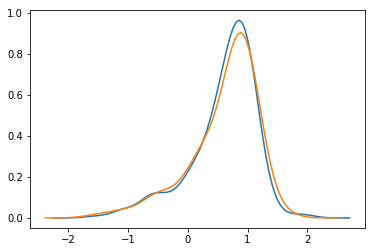

In [22]:
#训练 学习p(y)和p(x|y)
label = np.unique(train_3Y)
nc = label.shape[0]
nf = train_3X.shape[1]
p_y=PDL(train_3Y)
pdfs=PDF_x_Y(nc=nc,nf=nf,X=train_3X,Y=train_3Y)
#测试 对训练集和测试集分别进行
#训练集
pre = Classifier(train_3X,p_y,pdfs,label=label,nf=nf,nc=nc)
acc=np.count_nonzero(pre==train_3Y)
acc=acc*1.0/len(train_3Y)
print(acc*100,'%')
#测试集
pre = Classifier(test_3X,p_y,pdfs,label=label,nf=nf,nc=nc)
acc=np.count_nonzero(pre==test_3Y)
acc=acc*1.0/len(test_3Y)
print(acc*100,'%')
#画概率密度函数
plt.plot(pdfs[0][10][0],pdfs[0][10][1])
plt.plot(pdf3[0],pdf3[1])

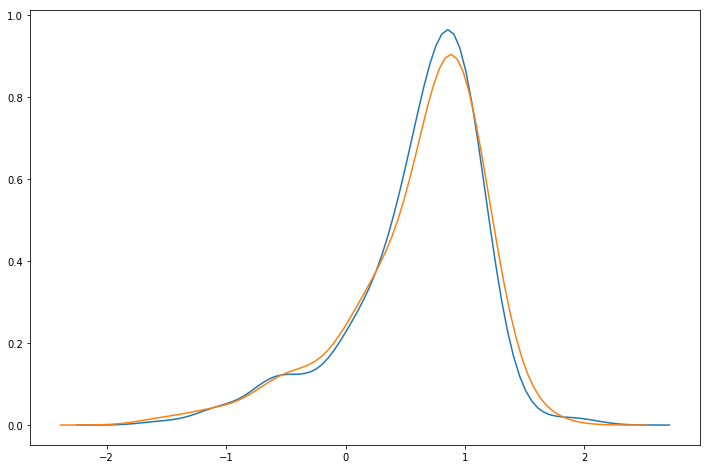

In [23]:
plt.figure(figsize=[12,8])
plt.plot(pdfs[0][10][0],pdfs[0][10][1])
plt.plot(pdf3[0],pdf3[1])